# Initializing libraries


In [1]:
pip install permutation

In [2]:
import time
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from collections import deque
from permutation import Permutation
from queue import Queue, PriorityQueue
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Defining Cubie Classes

In [3]:
class CornerCubie:
    
    __slots__ = ['orientation', 'ID']
    
    def __init__(self, ID, orientation = 0):
        self.orientation = orientation
        self.ID          = ID
        
        
    def __eq__(self, other):
        return self.ID == other.ID and self.orientation == other.orientation
    
    
    def __str__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    
    
    def __repr__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    

    def increment_orient_one(self):
        if   self.orientation == 0: return CornerCubie(self.ID, 1)
        elif self.orientation == 1: return CornerCubie(self.ID, 2)
        elif self.orientation == 2: return CornerCubie(self.ID, 0) 
        
        
    def increment_orient_two(self):
        if   self.orientation == 0: return CornerCubie(self.ID, 2)
        elif self.orientation == 1: return CornerCubie(self.ID, 0)
        elif self.orientation == 2: return CornerCubie(self.ID, 1) 


In [4]:
class EdgeCubie:
    
    __slots__ = ['orientation', 'ID']
    
    def __init__(self, ID, orientation = 0):
        self.orientation = orientation
        self.ID          = ID
        
        
    def __eq__(self, other):
        return self.ID == other.ID and self.orientation == other.orientation
    
    
    def __str__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    
    
    def __repr__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    

    def change_orientation(self):
        if self.orientation == 1  : return EdgeCubie(self.ID, 0)
        elif self.orientation == 0: return EdgeCubie(self.ID, 1)


In [5]:
# CORNER GOAL STATE CLASS INSTANCES
WRB = CornerCubie(1)    # Up-Front-Right
WRG = CornerCubie(2)    # Up-Front-Left
YRB = CornerCubie(3)    # Down-Front-Right
YRG = CornerCubie(4)    # Down-Front-Left
WOB = CornerCubie(5)    # Up-Back-Right
WOG = CornerCubie(6)    # Up-Back-Left
YOB = CornerCubie(7)    # Down-Back-Right
YOG = CornerCubie(8)    # Down-Back-Left

# EDGE GOAL STATE CLASS INSTANCES
WR = EdgeCubie(1)       # Up-Front
WB = EdgeCubie(2)       # Up-Right
WO = EdgeCubie(3)       # Up-Back
WG = EdgeCubie(4)       # Up-Left
RB = EdgeCubie(5)       # Front-Right
RG = EdgeCubie(6)       # Front-Left
OB = EdgeCubie(7)       # Back-Right
OG = EdgeCubie(8)       # Back-Left
YR = EdgeCubie(9)       # Down-Front
YB = EdgeCubie(10)      # Down-Right
YO = EdgeCubie(11)      # Down-Back
YG = EdgeCubie(12)      # Down-Left

# Defining list classes

In [6]:
class CornerList:
    
    GOAL = np.array([WRB, WRG, YRB, YRG, WOB, WOG, YOB, YOG])
    
    __slots__ = ['state', 'hashing']
    
    def __init__(self, state):
        self.state     = state
        self.hashing   = self.hashing_number()
        
    def __str__(self):
        return str(list(self.state))
    
    def __repr__(self):
        return str(list(self.state))
    
    def __eq__(self, other):
        return self.hashing == other.hashing

    def __hash__(self):
        return hash(self.hashing)
        
    """ Used as hashing function to put entries to dictionaries (hash tables) """
    def hashing_number(self):
        ori = int(''.join((str(corner.orientation) for corner in self.state[:-1])), 3)
        id = Permutation(*(corner.ID for corner in self.state)).lehmer(8)
        return id*(3**7) + ori

    """ Function used to check whether all corners are oriented """
    def is_oriented(self):
        for corner in self.state: 
            if corner.orientation != 0: return False
        return True

    """ Function used to update the state of corners via rotation """
    def rotate_corners(self, move):
        if   "U" in move:
            if "'" in move: new_state = self.rotate_corner_up(-90)
            elif "2" in move: new_state = self.rotate_corner_up(180)
            else: new_state = self.rotate_corner_up(90)
        elif "D" in move:
            if "'" in move: new_state = self.rotate_corner_down(-90)
            elif "2" in move: new_state = self.rotate_corner_down(180)
            else: new_state = self.rotate_corner_down(90)
        elif "F" in move:
            if "'" in move: new_state = self.rotate_corner_front(-90)
            elif "2" in move: new_state = self.rotate_corner_front(180)
            else: new_state = self.rotate_corner_front(90)
        elif "B" in move:
            if "'" in move: new_state = self.rotate_corner_back(-90)
            elif "2" in move: new_state = self.rotate_corner_back(180)
            else: new_state = self.rotate_corner_back(90)
        elif "R" in move:
            if "'" in move: new_state = self.rotate_corner_right(-90)
            elif "2" in move: new_state = self.rotate_corner_right(180)
            else: new_state = self.rotate_corner_right(90)
        elif "L" in move:
            if "'" in move: new_state = self.rotate_corner_left(-90)
            elif "2" in move: new_state = self.rotate_corner_left(180)
            else: new_state = self.rotate_corner_left(90)
        return CornerList(np.array(new_state))


    """
    The next functions are responsible for updating the state of the cube based
    on the face being rotation and on the direction of rotation. They work by swapping
    cubies of indexes on the list that hold all corner cubies.
    """
    
    def rotate_corner_up(self, angle):
        # ROTATING UP DOESN'T CHANGE CORNER ORIENTATION
        nstate = [item for item in self.state]
        if angle == 90   : nstate[1], nstate[5], nstate[0], nstate[4] = nstate[0], nstate[1], nstate[4], nstate[5]
        elif angle == -90: nstate[4], nstate[0], nstate[5], nstate[1] = nstate[0], nstate[1], nstate[4], nstate[5]
        elif angle == 180: nstate[5], nstate[4], nstate[1], nstate[0] = nstate[0], nstate[1], nstate[4], nstate[5]
        return np.array(nstate)


    def rotate_corner_down(self, angle):
        # ROTATING DOWN DOESN'T CHANGE CORNER ORIENTATION
        nstate = [item for item in self.state]
        if angle == 90   : nstate[3], nstate[7], nstate[2], nstate[6] = nstate[2], nstate[3], nstate[6], nstate[7]
        elif angle == -90: nstate[6], nstate[2], nstate[7], nstate[3] = nstate[2], nstate[3], nstate[6], nstate[7]
        elif angle == 180: nstate[7], nstate[6], nstate[3], nstate[2] = nstate[2], nstate[3], nstate[6], nstate[7]
        return np.array(nstate)


    def rotate_corner_front(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[0] = nstate[0].increment_orient_one()
            nstate[1] = nstate[1].increment_orient_two()
            nstate[2] = nstate[2].increment_orient_one()
            nstate[3] = nstate[3].increment_orient_two()
            nstate[2], nstate[0], nstate[3], nstate[1] = nstate[0], nstate[1], nstate[2], nstate[3] 
        elif angle == -90: 
            nstate[0] = nstate[0].increment_orient_one()
            nstate[1] = nstate[1].increment_orient_two()
            nstate[2] = nstate[2].increment_orient_one()
            nstate[3] = nstate[3].increment_orient_two()
            nstate[1], nstate[3], nstate[0], nstate[2] = nstate[0], nstate[1], nstate[2], nstate[3]
        elif angle == 180: 
            nstate[3], nstate[2], nstate[1], nstate[0] = nstate[0], nstate[1], nstate[2], nstate[3]
        return np.array(nstate)


    def rotate_corner_back(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[5] = nstate[5].increment_orient_one()
            nstate[6] = nstate[6].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_two()
            nstate[7] = nstate[7].increment_orient_two()
            nstate[6], nstate[4], nstate[7], nstate[5] = nstate[4], nstate[5], nstate[6], nstate[7]
        elif angle == -90: 
            nstate[5] = nstate[5].increment_orient_one()
            nstate[6] = nstate[6].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_two()
            nstate[7] = nstate[7].increment_orient_two()
            nstate[5], nstate[7], nstate[4], nstate[6] = nstate[4], nstate[5], nstate[6], nstate[7] 
        elif angle == 180: 
            nstate[7], nstate[6], nstate[5], nstate[4] = nstate[4], nstate[5], nstate[6], nstate[7]
        return np.array(nstate)


    def rotate_corner_right(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[2] = nstate[2].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_one()
            nstate[0] = nstate[0].increment_orient_two()
            nstate[6] = nstate[6].increment_orient_two()
            nstate[4], nstate[0], nstate[6], nstate[2] = nstate[0], nstate[2], nstate[4], nstate[6]  
        elif angle == -90: 
            nstate[2] = nstate[2].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_one()
            nstate[0] = nstate[0].increment_orient_two()
            nstate[6] = nstate[6].increment_orient_two()
            nstate[2], nstate[6], nstate[0], nstate[4] = nstate[0], nstate[2], nstate[4], nstate[6]
        elif angle == 180: 
            nstate[6], nstate[4], nstate[2], nstate[0] = nstate[0], nstate[2], nstate[4], nstate[6]
        return np.array(nstate)


    def rotate_corner_left(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[1] = nstate[1].increment_orient_one()
            nstate[7] = nstate[7].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_two()
            nstate[5] = nstate[5].increment_orient_two()
            nstate[5], nstate[1], nstate[7], nstate[3] = nstate[1], nstate[3], nstate[5], nstate[7]
        elif angle == -90:
            nstate[1] = nstate[1].increment_orient_one()
            nstate[7] = nstate[7].increment_orient_one()
            nstate[4] = nstate[4].increment_orient_two()
            nstate[5] = nstate[5].increment_orient_two()
            nstate[3], nstate[7], nstate[1], nstate[5] = nstate[1], nstate[3], nstate[5], nstate[7]
        elif angle == 180: 
            nstate[7], nstate[5], nstate[3], nstate[1] = nstate[1], nstate[3], nstate[5], nstate[7]
        return np.array(nstate)


In [7]:
class EdgeList:
    
    GOAL = np.array([WR, WB, WO, WG, RB, RG, OB, OG, YR, YB, YO, YG])
    
    __slots__ = ['state', 'hashing']
    
    def __init__(self, state):
        self.state     = state
        self.hashing   = self.hashing_number()
        
    def __str__(self):
        return str(list(self.state))
    
    def __repr__(self):
        return str(list(self.state))
    
    def __eq__(self, other):
        return self.hashing == other.hashing
        
    def hashing_number(self):
        ori = int(''.join((str(edge.orientation) for edge in self.state[:-1])), 2)
        id = Permutation(*(edge.ID for edge in self.state)).lehmer(12)
        return id*(2**11) + ori

    def is_oriented(self):
        for edge in self.state: 
            if edge.orientation != 0: return False
        return True

    """ Checks whether edges of layer E are located there """
    def edges_layer_E(self):
        edges_E = EdgeList.GOAL[4], EdgeList.GOAL[5], EdgeList.GOAL[6], EdgeList.GOAL[7]
        a = self.state[4] in edges_E
        b = self.state[5] in edges_E
        c = self.state[6] in edges_E
        d = self.state[7] in edges_E
        if a and b and c and d: return True
        else: return False

    """ Performs rotation of edge cubies by updating locations of cubies on list """
    def rotate_edges(self, move):
        if "U" in move:
            if "'" in move: new_state = self.rotate_edge_up(-90)
            elif "2" in move: new_state = self.rotate_edge_up(180)
            else: new_state = self.rotate_edge_up(90)
        elif "D" in move:
            if "'" in move: new_state = self.rotate_edge_down(-90)
            elif "2" in move: new_state = self.rotate_edge_down(180)
            else: new_state = self.rotate_edge_down(90)
        elif "F" in move:
            if "'" in move: new_state = self.rotate_edge_front(-90)
            elif "2" in move: new_state = self.rotate_edge_front(180)
            else: new_state = self.rotate_edge_front(90)
        elif "B" in move:
            if "'" in move: new_state = self.rotate_edge_back(-90)
            elif "2" in move: new_state = self.rotate_edge_back(180)
            else: new_state = self.rotate_edge_back(90)
        elif "R" in move:
            if "'" in move: new_state = self.rotate_edge_right(-90)
            elif "2" in move: new_state = self.rotate_edge_right(180)
            else: new_state = self.rotate_edge_right(90)
        elif "L" in move:
            if "'" in move: new_state = self.rotate_edge_left(-90)
            elif "2" in move: new_state = self.rotate_edge_left(180)
            else: new_state = self.rotate_edge_left(90)
        return EdgeList(np.array(new_state))


    """
    The next functions are responsible for rotating edge cubies according to the
    face being rotated. The location of the affected cubies is updated on the list
    of cubies, and their orientations are flipped when necessary.
    """

    # Notice that all edges that appear in Up are in the first 4 places of the list
    def rotate_edge_up(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : updates = np.array([nstate[1], nstate[2], nstate[3], nstate[0]])
        elif angle == -90: updates = np.array([nstate[3], nstate[0], nstate[1], nstate[2]])
        elif angle == 180: updates = np.array([nstate[2], nstate[3], nstate[0], nstate[1]])
        return np.concatenate((updates, nstate[4:]))



    # Notice that all edges that appear in DOWN are in the first 4 places of the list
    def rotate_edge_down(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : updates = np.array([nstate[9], nstate[10], nstate[11], nstate[8]])
        elif angle == -90: updates = np.array([nstate[11], nstate[8], nstate[9], nstate[10]])
        elif angle == 180: updates = np.array([nstate[10], nstate[11], nstate[8], nstate[9]])
        return np.concatenate((nstate[0:8], updates))



    # Rotating Front or Back flip the orientation of all four edges in that face
    # Notice that all edges that appear in Front are in indexes 0, 4, 5, 8
    def rotate_edge_front(self, angle):
        nstate = [item for item in self.state]
        if angle != 180: 
            for i in [0, 4, 5, 8]: nstate[i] = nstate[i].change_orientation()
        if angle == 90   : nstate[0], nstate[4], nstate[5], nstate[8] = nstate[5], nstate[0], nstate[8], nstate[4]  
        elif angle == -90: nstate[0], nstate[4], nstate[5], nstate[8] = nstate[4], nstate[8], nstate[0], nstate[5]
        elif angle == 180: nstate[0], nstate[4], nstate[5], nstate[8] = nstate[8], nstate[5], nstate[4], nstate[0]
        return np.array(nstate)



    # Notice that all edges that appear in Back are in indexes 2, 6, 7, 10
    def rotate_edge_back(self, angle):
        nstate = [item for item in self.state]
        if angle != 180: 
            for i in [2, 6, 7, 10]: nstate[i] = nstate[i].change_orientation()
        if angle == 90   : nstate[2], nstate[6], nstate[7], nstate[10] = nstate[7], nstate[2], nstate[10], nstate[6]  
        elif angle == -90: nstate[2], nstate[6], nstate[7], nstate[10] = nstate[6], nstate[10], nstate[2], nstate[7]
        elif angle == 180: nstate[2], nstate[6], nstate[7], nstate[10] = nstate[10], nstate[7], nstate[6], nstate[2]
        return np.array(nstate)



    # Notice that all edges that appear in Right are in indexes 1, 4, 6, 9
    def rotate_edge_right(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[6], nstate[1], nstate[9], nstate[4] = nstate[1], nstate[4], nstate[6], nstate[9]  
        elif angle == -90: nstate[4], nstate[9], nstate[1], nstate[6] = nstate[1], nstate[4], nstate[6], nstate[9]
        elif angle == 180: nstate[9], nstate[6], nstate[4], nstate[1] = nstate[1], nstate[4], nstate[6], nstate[9]
        return np.array(nstate)



    # Notice that all edges that appear in Right are in indexes 3, 5, 7, 11
    def rotate_edge_left(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[7], nstate[3], nstate[11], nstate[5] = nstate[3], nstate[5], nstate[7], nstate[11]  
        elif angle == -90: nstate[5], nstate[11], nstate[3], nstate[7] = nstate[3], nstate[5], nstate[7], nstate[11]
        elif angle == 180: nstate[11], nstate[7], nstate[5], nstate[3] = nstate[3], nstate[5], nstate[7], nstate[11]
        return np.array(nstate)


In [8]:
wrb = CornerCubie(1)    # Up-Front-Right
wrg = CornerCubie(2)    # Up-Front-Left
yrb = CornerCubie(3)    # Down-Front-Right
yrg = CornerCubie(4)    # Down-Front-Left
wob = CornerCubie(5)    # Up-Back-Right
wog = CornerCubie(6)    # Up-Back-Left
yob = CornerCubie(7)    # Down-Back-Right
yog = CornerCubie(8)    # Down-Back-Left


wr = EdgeCubie(1)       # Up-Front
wb = EdgeCubie(2)       # Up-Right
wo = EdgeCubie(3)       # Up-Back
wg = EdgeCubie(4)       # Up-Left
rb = EdgeCubie(5)       # Front-Right
rg = EdgeCubie(6)       # Front-Left
ob = EdgeCubie(7)       # Back-Right
og = EdgeCubie(8)       # Back-Left
yr = EdgeCubie(9)       # Down-Front
yb = EdgeCubie(10)      # Down-Right
yo = EdgeCubie(11)      # Down-Back
yg = EdgeCubie(12)      # Down-Left


corner_state = CornerList(np.array([wrb, wrg, yrb, yrg, wob, wog, yob, yog]))
edge_state = EdgeList(np.array([wr, wb, wo, wg, rb, rg, ob, og, yr, yb, yo, yg]))

In [9]:
class CubeNode:

    __slots__ = ['state', 'gval', 'parent', 'parentMove', 'fval']

    GOAL = [CornerList(np.array([WRB, WRG, YRB, YRG, WOB, WOG, YOB, YOG])), 
            EdgeList(np.array([WR, WB, WO, WG, RB, RG, OB, OG, YR, YB, YO, YG]))]

    def __init__(self, state, parent = None, move = None, gval = 0):
        self.state      = state
        self.parent     = parent
        self.parentMove = move
        self.gval       = gval
        self.fval       = gval + self.misplaced_tiles()

    def __eq__(self, other):
        return self.state[0] == other.state[0] and self.state[1] == other.state[1]

    def __hash__(self):
        return hash((self.state[0].hashing, self.state[1].hashing))

    def __str__(self):
        return str([str(self.state[0]), str(self.state[1])])

    def __repr__(self):
        return str([str(self.state[0]), str(self.state[1])])

    def __lt__(self, other):
        return self.fval < other.fval

    def rotate(self, move):
        corners = self.state[0] 
        edges   = self.state[1] 
        return CubeNode([corners.rotate_corners(move), edges.rotate_edges(move)], parent=self, move=move, gval=self.gval+1)
    
    def misplaced_tiles(self): 
        misplaced = 0
        for i in range(len(self.state[1].state)):
            edge = self.state[1].state[i]
            if i != (edge.ID - 1): misplaced += 1
        return misplaced/4

    def phase_1_test(self):
        if self.state[1].is_oriented(): return True
        else: return False
    
    def phase_2_test(self):
        if self.state[0].is_oriented() and self.state[1].edges_layer_E(): return True
        else: return False
 
    def goal_test(self):
        corners = self.state[0] 
        edges   = self.state[1] 
        if corners == CubeNode.GOAL[0] and edges == CubeNode.GOAL[1]: return True
        else: return False

# Thistlethwaite’s Algorithm

## Helper Functions

In [10]:
'''
This function takes the solved cube and shuffles it to generate instances of the cube that we can try to
solve using the developed solver algorithm. I chose to generate instances of the cube by shuffling it using
the allowed moves rather than randomly choosing a state because not all cube states generated randomly are
solvable. Shuffling the cube using the allowed moves guarantees that the cube is solvable.
'''
def shuffle(goal, min, max):
    possibleMoves = ["U", "U'", "U2", "D", "D'", "D2", "F", "F'", "F2", "B", "B'", "B2", "R", "R'", "R2", "L", "L'", "L2"]
    moves = np.random.choice(possibleMoves, np.random.randint(min, max, 1))
    actualMoves = []
    for move in moves: 
        if moveChecks(goal, move): 
            goal = goal.rotate(move)
            actualMoves.append(move)
    goal.gval = 0
    goal.parent = None
    goal.parentMove = None
    return goal, actualMoves

In [11]:
'''
This function presents a series of if then statements for checking whether the current move would
conflict with other moves done. For instance, if the previous move (move that generated current node)
was U and the current move (move to be performed by node) is U, then this sequence of moves is the
same as performing a half twist of U (aka U2 move), which was done before. If such a situation happens,
this function returns False so that we can avoid generating a node again. I use this function under the
assumption that generating a node again for checking it on the body of the function costs more memory
and time compared to performing this series of if-then checks.
'''
def moveChecks(node, move):
    if node.parent:
        previousMove = node.parentMove                                              # Examples:
        if previousMove == move: return False                                       # [U, U] = U2
        if '2' in previousMove and previousMove[0] == move[0]: return False         # [U2, U] = U'; [U2, U'] = U; [U2, U2] = no move
        if '2' in move and move[0] == previousMove[0]: return False                 # [U, U2] = U'; [U', U2] = U; [U2, U2] = no move
        if "'" in previousMove and previousMove[0] == move[0]: return False         # [U', U] = no move
        if "'" in move and move[0] == previousMove[0]: return False                 # [U, U'] = no move
        return True
    else: return True

## Phase 1

Given any scrambeled cube, phase 1 searches for a state where all edges of the cube are correctly oriented. In other words, phase 1 returns a node where its edges have an orientation 0. Since only quarter turns of the front and back faces can change the orientation of edges, we can find a solution for the cube ignoring front and back quarter turns if the cube has all edges correctly oriented. Thus, finding a goal for phase 1 allows us to search for a solution, starting from that phase 1 goal node, without considering F, F', B, and B'.

In [12]:
'''
A* SEARCH USING NUMBER OF MISPLACED CUBIES AS HEURISTIC

This function implements the first phase of the Rubik's cube solver -- given a scrambeled cube, it searches
for a state where all edges of the cube are correctly oriented (i.e., all edges have orientation 0). If we
find such state, then we will be able to reduce the branching factor by four by removing moves that would
alter the orientation of edges (removing moves F, F', B, B'), which is what phase 2 does.
'''
def phase1(node):
    frontier, explored = PriorityQueue(), {node}                    # initializing frontier queue and explored set
    if node.phase_1_test(): return node                             # check whether test of phase 1 is complete
    frontier.put(node)                                              # putting initial node to frontier
    moves = ["U", "U'", "U2", "D", "D'", "D2", "F", "F'", "F2",     # saves all possible moves to a list
             "B", "B'", "B2", "R", "R'", "R2", "L", "L'", "L2"]

    while not frontier.empty():                                     # while frontier is not empty
        node = frontier.get()                                       # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):                              # checks if move doesn't make state return to what it was before
                child = node.rotate(move)                           # generate a new child using move
                if child.phase_1_test(): return child               # return child if all edges are oriented
                if child in explored or child.gval > 7: continue    # if child in explored or too far away from node, continue
                explored.add(child)                                 # add child to explored set
                frontier.put(child)                                 # put child in frontier according to fval

## Phase 2

This phase is responsible for finding a state where all corners are correctly oriented and the edges of the E layer are on the E layer. Since quarter turns of the front, back, right, and left faces change the orientation of a corner, but we don't have quarter turns of the front and the back faces on this step, only R, R', L, and L' can change a corner's orientation. Furthermore, rotation of up and down faces cannot change the edges that are in the E slice. Thus, we need to make the edges whose home are in the E layer get there still on this phase.

In [13]:
"""
This function generates a list of all configurations of corner cubies that obey the 
goal of phase 2 -- all corners are corrently oriented. It uses breadth-first search to
generate the list as the algorithm is complete.
"""
def generateP2CornerGoals(goalNode):
    frontier, explored = deque([goalNode.state[0]]), {goalNode.state[0]}
    moves = ["U", "U'", "U2", "D", "D'", "D2", "F2", "B2", "R2", "L2"]      # only moves that do not change corner orientation
    while frontier:
        cornerNode = frontier.popleft()                                     # pop oldest node from frontier
        for move in moves:                                                  # iterate through all possible moves
            cornerChild = cornerNode.rotate_corners(move)                   # generate corner using move
            if cornerChild in explored: continue                            # check whether corner configuration was already explored
            explored.add(cornerChild)                                       # add configuration to explroed set
            frontier.append(cornerChild)                                    # add configuration to frontier for expanding later
    return list(explored)                                                   # return list of all configurations generated thay obey phase 2 goal



"""
Using the goals generated by the function above, this function generates a pattern
database for the corners.
"""
def createP2PatternDB(goalList):
    frontier, explored = deque(goalList), {cornerNode: 0 for cornerNode in goalList}
    moves = ["F2", "B2", "U", "U'", "U2", "D", "D'", "D2", "R", "R'", "R2", "L", "L'", "L2"]
    while frontier:
        cornerNode = frontier.popleft()
        if explored[cornerNode] > 2: return explored
        for move in moves:
            cornerChild = cornerNode.rotate_corners(move)
            if cornerChild in explored: continue
            explored[cornerChild] = explored[cornerNode] + 1
            frontier.append(cornerChild)
    



# All corners are oriented and the four edges (FR, FL, BR, BL) are in the E slice (layer between up and down)
def phase2(node):
    frontier, explored = PriorityQueue(), {node}                        # initializing objects
    if node.phase_2_test(): return node                                 # check if phase 2 test is successful
    frontier.put(node)                                                  # putting initial node to frontier
    iGval = node.gval
    moves = ["F2", "B2", "U", "U'", "U2", "D", "D'",                    # saves moves to a list (remove F and B single turns)
             "D2", "R", "R'", "R2", "L", "L'", "L2"]
    
    while not frontier.empty():                                         # while frontier is not empty
        node = frontier.get()                                           # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):
                child = node.rotate(move)                               # generate a new child using given move
                if child.phase_2_test(): return child                   # if both conditions are true, return child
                if child in explored or child.gval>iGval+10: continue   # if child in explored or too far away from node, continue
                if child.state[0] in phase2DB:
                    child.fval = child.gval + phase2DB[child.state[0]]
                else: child.fval = child.gval + 3
                explored.add(child)                                     # add child to explored
                frontier.put(child)                                     # put child in frontier according to fval

## Phase 3

This phase is responsible for finding a state where the cube can be solved using only half twists. Thus, we need to find a state where all edges are on their correct layer since half turns do not change edges of layer, but only permute edges on their current layer. Furthermore, all corners need to be on their correct orbit, which means that they can be moved to their correct position using only half turns. 

In [14]:
"""
Generating all possible corners configurations that can be achieved from the goal using
only half turns using breadth-first search
"""
def generateP3CornerGoals(goal):
    frontier, explored = deque([goal.state[0]]), {goal.state[0]}
    moves = ["U2", "D2", "F2", "B2", "R2", "L2"]
    while frontier:                                         
        cornerNode = frontier.popleft()                         # pop oldest node from frontier
        for move in moves:                                      # iterate through every possible move
            cornerChild = cornerNode.rotate_corners(move)        # generate child node by rotating parent according to move
            if cornerChild in explored: continue                # if state was seen before, continue 
            explored.add(cornerChild)                           # add child to explored dictionary
            frontier.append(cornerChild)                        # add child to frontier so it can be expanded
    return explored                                             # return pattern DB



"""
Creates pattern database for states of phase 3. It uses BFS for generating the 
database, and the allowed moves are all the ones allowed in phase 3.
"""
def createP3PatternDB(goalList):
    frontier, explored = deque(goalList), {cornerNode: 0 for cornerNode in goalList}
    moves = ["R2", "L2", "F2", "B2", "U", "U'", "U2", "D", "D'", "D2"]
    while frontier:
        cornerNode = frontier.popleft()
        for move in moves:
            cornerChild = cornerNode.rotate_corners(move)
            if cornerChild in explored: continue
            explored[cornerChild] = explored[cornerNode] + 1
            frontier.append(cornerChild)
    return explored




"""
This function implements phase 3 of the Rubik's cube solver. It takes a goal from phase 2 (all corners are
oriented and edges of the E layer are in that layer) and searches for nodes where all edges are on their
home layers, the corners are on their correct orbits, and the cube has overall even parity. 
"""
def phase3(node):
    frontier, explored = PriorityQueue(), {}                            # initializing objects
    if node in phase4DB: return node                                    # check if phase 3 test is successful
    frontier.put(node)                                                  # putting initial node to frontier
    iGval = node.gval                                                   # saves initial node's gval for future reference
    moves = ["R2", "L2", "F2", "B2", "U",                               # saves moves to a list (removes R and L quater turns)
             "U'", "U2", "D", "D'", "D2"]
    
    while not frontier.empty():                                         # while frontier is not empty
        node = frontier.get()                                           # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):                                  # check if move doesn't conflict with previous
                child = node.rotate(move)                               # generate a new child using given move
                if child in phase4DB: return child                      # if all four conditions are true, return child
                if child in explored or child.gval>iGval+14: continue   # if child in explored or too far away from node, continue
                child.fval = child.gval + phase3DB[child.state[0]]
                explored[child] = True                                  # add child to explored
                frontier.put(child)                                     # put child in frontier according to fval

## Phase 4

This phase is responsible for solving the cube. Since the starting node on this phase has all edges correctly oriented and on their correct layer, and it also has all corners correctly oriented and on their correct orbit, this phase requires only quarter turns to reach the solved state. In order to make exploration even faster, I created a database that holds the exact solution from any instance of the cube in phase 4 to the solved cube.

In [15]:
"""
This functions creates a database for phase 4 of the algorithm. It starts at the solved cube and 
uses breadth first search to generate EVERY possible cube state by using only the moves allowed in phase
4 of the algorithm (half turns). The breadth first approach ensures that the distances entered in the DB
are the minimum amount of moves required to reach the goal state from the given configuration. The results
here are called by the phase4 function.
"""
def createP4DB(goal):
    frontier, explored = deque([goal]), {goal: goal}            # initializing objects
    moves = ["U2", "D2", "F2", "B2", "R2", "L2"]                # saving possible moves to a list
    while frontier:                                         
        node = frontier.popleft()                               # pop oldest node from frontier
        for move in moves:                                      # iterate through every possible move
            child = node.rotate(move)                           # create child node by rotating parent according to move
            if child in explored: continue                      # if state was seen before, continue as this is a worst path to state
            explored[child] = child                             # add child to explored dictionary
            frontier.append(child)                              # add child to frontier so it can be expanded
    return explored                                             # return pattern DB



"""
Since the number of possible states in this phase isn't large, we could generate and store all paths
to the goal. Thus, this function only needs to take the initial node of phase 4 for two things: (1) to
retrieve the best path from that node to the goal, and to retrieve the path made to get from the very first
initial state to the current node.
"""
def phase4(node):
    nodeDB = phase4DB[node]                        # same state as 'node' but class instance obtained from the database
    finalSteps = []                                # list will be inverted (start from the goal and go to nodeDB)
    while nodeDB.parent:                    
        finalSteps.append(nodeDB.parentMove)       # append move from parent to current node to step list
        nodeDB = nodeDB.parent                     # get parent of node
    for move in finalSteps[::-1]:                  # rotate node according to list from phase 4 DB to get complete route to goal
        node = node.rotate(move)     
    del finalSteps                                 # delete steps list to save memory
    return node                                    # return solved cube

## Solver function

In [16]:
"""
This function takes the solution node and gets the solution steps by moving
up the tree by getting the attribute node.parentMove
"""
def get_steps(final_node):
    node = final_node
    steps = []
    while node.parent:
        steps.append(node.parentMove)
        node = node.parent
    return steps[::-1]


"""
This function takes a shuffled node and searches for the solution, executing all
four phases of the algorithm. It returns the final node and the steps taken for
retrieving the solution.
"""
def solve_cube(shuffled_node):
    print("Executing phase 1")
    current_node = phase1(shuffled_node)
    print("Executing phase 2")
    current_node = phase2(current_node)
    print("Executing phase 3")
    current_node = phase3(current_node)
    print("Executing phase 4")
    final_node  = phase4(current_node)
    if final_node.goal_test(): print("Cube is solved!!")
    steps = get_steps(final_node)
    return final_node, steps

# Execution

In [17]:
# Generate Solution Node for shuffling

edge_state    = EdgeList(np.array([wr, wb, wo, wg, rb, rg, ob, og, yr, yb, yo, yg]))
corner_state  = CornerList(np.array([wrb, wrg, yrb, yrg, wob, wog, yob, yog]))
goal          = CubeNode([corner_state, edge_state])

In [18]:
# Creates the pattern databases

p2_corners_goal = generateP2CornerGoals(goal)            # creates phase 2 corner goals 
phase2DB      = createP2PatternDB(p2_corners_goal)       # creates phase 2 pattern DB
del p2_corners_goal

p3_corners_goal = generateP3CornerGoals(goal)            # creates phase 3 corner goals
phase3DB      = createP3PatternDB(p3_corners_goal)       # creates phase 3 pattern DB
del p3_corners_goal

phase4DB      = createP4DB(goal)                         # creates database for all solutions to phase 4

In [22]:
 # Solves a cube

initial_node, shuffling_moves = shuffle(goal, 2, 6)
solution_node, solution_steps = solve_cube(initial_node)

print()
print("Number of moves: ", solution_node.gval)
print("Shuffling moves: ", shuffling_moves)
print("Solution moves : ", solution_steps)

Executing phase 1
Executing phase 2
Executing phase 3
Executing phase 4

Number of moves:  27
Shuffling moves:  ['F', 'U']
Solution moves :  ["U'", 'F', 'R', "U'", 'L2', 'U', 'R', 'D2', 'R2', "U'", 'B2', "U'", 'L2', 'U', 'L2', 'U', 'F2', 'U2', 'F2', 'U2', 'R2', 'B2', 'R2', 'U2', 'F2', 'U2', 'B2']


## Solution Analysis

In [ ]:
'''
This function solves multiple instances of Rubik's cube. It returns the number of moves
used for shuffling the cube, the set of steps of the solutions, and the time that it
took the algorithm for finding a solution.
'''
def solve_multiple_cubes(iterations, min, max):
    number_moves, solutions, timing = [], [], []
    for i in range(iterations):
        initial_node, shuffling_moves = shuffle(goal, min, max)       # gets random instance of cube to solve and moves to get there
        number_moves.append(len(shuffling_moves))                     # append number of moves to list
        print(f"SOLVING CUBE {i+1}")
        start = time.time()                                           # starts recording time to solve cube
        solutions.append(solve_cube(initial_node)[1])                 # append list of moves of solution
        end = time.time()                                             # ends recording time to solve cube
        timing.append(end - start)                                    # gets time needed to solve instance of cube and adds to list
        clear_output(True)
    return number_moves, solutions, timing                            # returns list of variables for graphs

In [ ]:
# Generates lists for evaluating performance of algorithms

moves_list1, solution_lists1, time_to_solve1 = solve_multiple_cubes(70, 2, 8)    # range 1
moves_list2, solution_lists2, time_to_solve2 = solve_multiple_cubes(30, 8, 14)   # range 2

solution_depth1 = [len(lst) for lst in solution_lists1]
solution_depth2 = [len(lst) for lst in solution_lists2]

SOLVING CUBE 30
Executing phase 1
Executing phase 2
Executing phase 3
Executing phase 4


In [ ]:
overall_moves = np.asarray(moves_list1 + moves_list2)
overall_sol_depth = np.asarray(solution_depth1 + solution_depth2)
overall_time  = np.asarray(time_to_solve1 + time_to_solve2)

#np.save("moves", overallMoves)
#np.save("depth", overallSolDepth)
#np.save("time", overallTime)

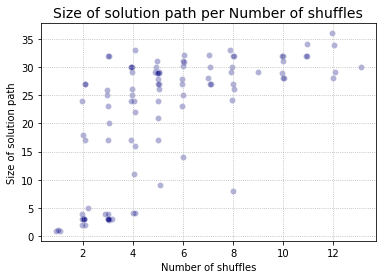

In [ ]:
import seaborn as sns
sns.scatterplot(x = overall_moves + np.random.normal(0, 0.05, overall_moves.shape), 
                y = overall_sol_depth + np.random.normal(0, 0.05, overall_sol_depth.shape), 
                marker="o", color="navy", alpha=0.3)

plt.title("Size of solution path per Number of shuffles", fontsize = 14)
plt.xlabel("Number of shuffles")
plt.ylabel("Size of solution path")
plt.grid(ls=":")
plt.show()

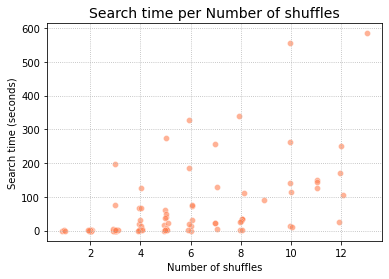

In [ ]:
sns.scatterplot(x = overall_moves + np.random.normal(0, 0.05, overall_moves.shape), 
                y = overall_time + + np.random.normal(0, 0.5, overall_time.shape), 
                marker="o", color="coral", alpha=0.6)
                
plt.title("Search time per Number of shuffles", fontsize = 14)
plt.ylabel("Search time (seconds)")
plt.xlabel("Number of shuffles")
plt.grid(ls=":")
plt.show()

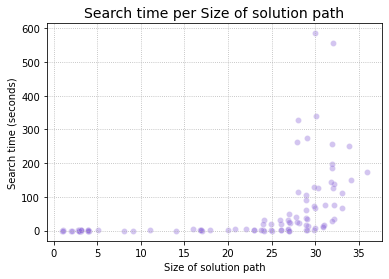

In [ ]:
sns.scatterplot(x = overall_sol_depth + np.random.normal(0, 0.1, overall_sol_depth.shape), 
                y = overall_time + np.random.normal(0, 0.5, overall_time.shape), 
                marker="o", color="mediumpurple", alpha=0.4)

plt.title("Search time per Size of solution path", fontsize = 14)
plt.ylabel("Search time (seconds)")
plt.xlabel("Size of solution path")
plt.grid(ls=":")
plt.show()